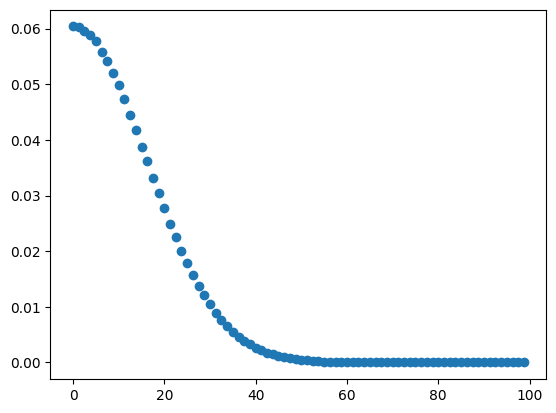

In [24]:
import numpy as np

import matplotlib.pyplot as plt

def softmax(x):

    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

class TwoNomal():
    def __init__(self,mu1,mu2,sigma1,sigma2):
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2
    def doubledensity(self,x):
            mu1 = self.mu1
            sigma1 = self.sigma1
            mu2 = self.mu2
            sigma2 = self.sigma1
            N1 = np.sqrt(2 * np.pi * np.power(sigma1, 2))
            fac1 = np.power(x - mu1, 2) / np.power(sigma1, 2)
            density1=np.exp(-fac1/2)/N1

            N2 = np.sqrt(2 * np.pi * np.power(sigma2, 2))
            fac2 = np.power(x - mu2, 2) / np.power(sigma2, 2)
            density2=np.exp(-fac2/2)/N2
            #print(density1,density2)
            density=0.5*density2+0.5*density1
            return density

N2 = TwoNomal(0,0,16,16)

#创建等差数列作为X
X = np.arange(0,100,1.25)
#print(X)
Y_ori = N2.doubledensity(X)


# def shuffle_part(p,x_start, x_end):
#     temp = p[x_start:x_end]
#     np.random.shuffle(temp)
#     p[x_start:x_end]=temp.copy()
#     return p

# Y = shuffle_part(Y, 5, 40)
# Y = shuffle_part(Y, 45, 80)

# np.random.shuffle(Y_ori)

# Y[Y>0.02]+= 1
# Y[Y<0.02Y>0.01]-= 0.01

Y = []
for i in Y_ori:
    Y.append(i*(1.0+0.01*np.random.rand()))
Y = np.array(Y)
Y = Y/sum(Y)
# Y = softmax(Y)


#print(Y)
plt.scatter(X,Y)

plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from tqdm import tqdm, trange

torch.manual_seed(1)
class FR_KL(nn.Module):
    def __init__(self, k):
        super(FR_KL, self).__init__()
        self.q = nn.Parameter(torch.rand(k).to(float))
        torch.unsqueeze(self.q, 0)
#         self.q = nn.Parameter(torch.tensor([[-2.1,-4.2,-3.6,-2.0],[-5.3,-3.0,-4.1,-2.1]]))
        
    def set_q(self, q_bake):
        self.q = nn.Parameter(copy.deepcopy(q_bake))

    def forward(self, p, f):
        # forward 
        if f=="f":
            qq = F.log_softmax(self.q, dim=-1)
            return F.kl_div(qq,p.log(),log_target=True,reduction="batchmean") 
        elif f=="r": #reverse
            qq = F.log_softmax(self.q, dim=-1)
            return F.kl_div(p.log(),qq,log_target=True, reduction="batchmean") 
        elif f=="fr": #reverse
            qq = F.log_softmax(self.q, dim=-1)
            return 0.5*F.kl_div(qq,p.log(),log_target=True,reduction="batchmean") +0.5*F.kl_div(p.log(),qq,log_target=True, reduction="batchmean") 
    

def learn(p, flag, N=800):
    optimizer = optim.Adam(A.parameters(), lr=0.2)#, weight_decay=0.1)
    result = []
    q_s = []
    t=F.softmax(A.q, dim=-1).detach().numpy()
    q_s.append(t)
    for i in trange(N):
        loss = A(p,flag)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        result.append(loss.item())
        t=F.softmax(A.q, dim=-1).detach().numpy()
        q_s.append(t)
    print("final loss", loss)
    del optimizer
    return q_s, result

# class_K = 1000
# p = (torch.rand((128, class_K))*2-1)
# p = nn.Parameter(torch.tensor([[-1.4,-3.0,-2.2,-4.0],[-1.4,-3.0,-2.4,-1.2]]))

p = nn.Parameter(torch.from_numpy(Y)).to(float)
torch.unsqueeze(p, 0)
p.requires_grad = False

A = FR_KL(p.size()[-1])

q = copy.deepcopy(A.q)
print(q)
p1 = copy.deepcopy(p)
p2 = copy.deepcopy(p)

fq_s, res1=learn(p1, "f")


A.set_q(q)

rq_s, res2=learn(p2, "r")


A.set_q(q)



Parameter containing:
tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999, 0.3971, 0.7544, 0.5695,
        0.4388, 0.6387, 0.5247, 0.6826, 0.3051, 0.4635, 0.4550, 0.5725, 0.4980,
        0.9371, 0.6556, 0.3138, 0.1980, 0.4162, 0.2843, 0.3398, 0.5239, 0.7981,
        0.7718, 0.0112, 0.8100, 0.6397, 0.9743, 0.8300, 0.0444, 0.0246, 0.2588,
        0.9391, 0.4167, 0.7140, 0.2676, 0.9906, 0.2885, 0.8750, 0.5059, 0.2366,
        0.7570, 0.2346, 0.6471, 0.3556, 0.4452, 0.0193, 0.2616, 0.7713, 0.3785,
        0.9980, 0.9008, 0.4766, 0.1663, 0.8045, 0.6552, 0.1768, 0.8248, 0.8036,
        0.9434, 0.2197, 0.4177, 0.4903, 0.5730, 0.1205, 0.1452, 0.7720, 0.3828,
        0.7442, 0.5285, 0.6642, 0.6099, 0.6818, 0.7479, 0.0369, 0.7517],
       dtype=torch.float64, requires_grad=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 2705.74it/s]


final loss tensor(1.1492e-06, dtype=torch.float64, grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 2555.54it/s]

final loss tensor(5.1159e-06, dtype=torch.float64, grad_fn=<DivBackward0>)


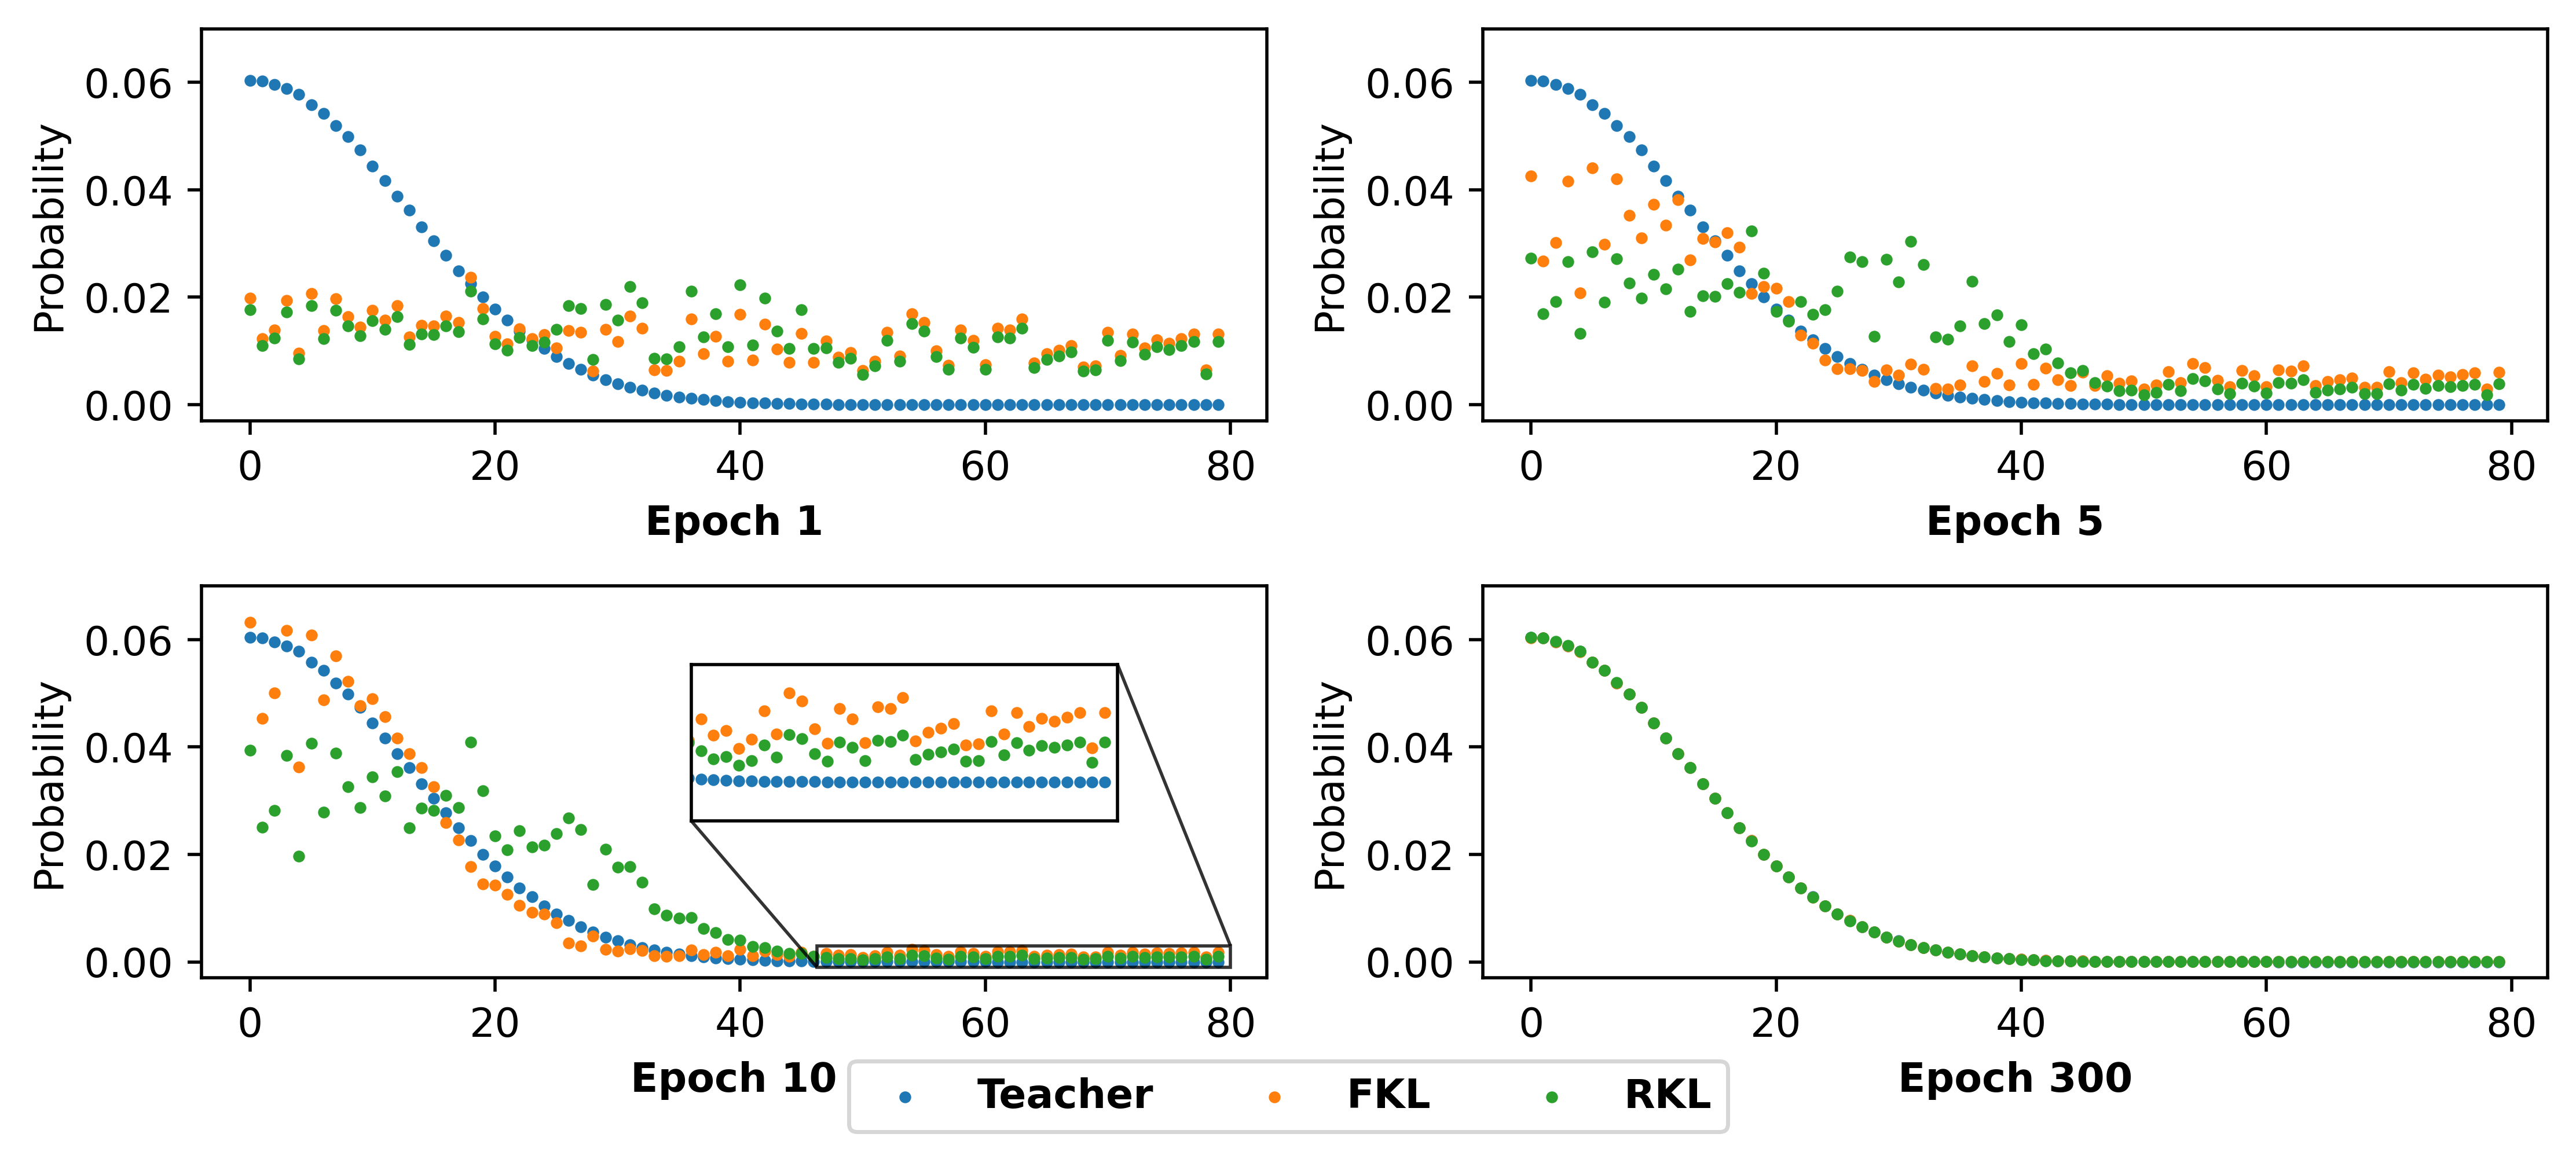

In [29]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager


X = np.arange(0,len(X), 1)
ss=15

fig, axs = plt.subplots(2,2, figsize=(9, 4), dpi=500)


idxs = [1,5,10,300]
for x in range(2):
    for y in range(2):
        idx = idxs[int(2*x+y)]
        axs[x,y].scatter(X,Y,  c='#1f77b4', marker='.', s=ss)
        axs[x,y].scatter(X,fq_s[idx], c='#ff7f0e', marker='.', s=ss)
        axs[x,y].scatter(X,rq_s[idx], c='#2ca02c', marker='.', s=ss)
        axs[x,y].set_xlabel("Epoch {}".format(idx),weight='bold')
        axs[x,y].set_ylabel("Probability")
        axs[x,y].set_ylim(-0.003, 0.07)
#         axs[x,y].set_yscale('log')

axins = axs[1,0].inset_axes((0.46, 0.4, 0.4, 0.4))
idx = idxs[2]
axins.scatter(X,Y,  c='#1f77b4', marker='.', s=ss)
axins.scatter(X,fq_s[idx], c='#ff7f0e', marker='.', s=ss)
axins.scatter(X,rq_s[idx], c='#2ca02c', marker='.', s=ss)
axins.set_xlim(46.25,80)
axins.set_ylim(-0.001,0.003)
axins.yaxis.set_major_locator(plt.NullLocator())
axins.xaxis.set_major_locator(plt.NullLocator())
mark_inset(axs[1,0], axins, loc1=1, loc2=3, fc="none", ec='k', lw=0.8, alpha=0.8)

# axins = axs[1,0].inset_axes((0.1, 0.15, 0.5, 0.1))
# idx = idxs[2]
# axins.scatter(X,Y,  c='#1f77b4', marker='.', s=ss)
# axins.scatter(X,fq_s[idx], c='#ff7f0e', marker='.', s=ss)
# axins.scatter(X,rq_s[idx], c='#2ca02c', marker='.', s=ss)
# axins.set_xlim(39,49)
# axins.set_ylim(-0.001,0.003)
# axins.yaxis.set_major_locator(plt.NullLocator())
# axins.xaxis.set_major_locator(plt.NullLocator())
# mark_inset(axs[1,0], axins, loc1=1, loc2=3, fc="none", ec='k', lw=0.5, alpha=0.7)


# axs[0,1].add_patch(plt.Rectangle((50,0.02), 10, 0.02, ls="--", lw=1, ec="crimson", fc="none"))


font = font_manager.FontProperties(weight='bold',style='normal', size=10)
# fig.legend(loc='best')
legendEntries = ("Teacher","FKL","RKL")
# set figure legend entries, number of columns, location
fig.legend(legendEntries,ncol=len(legendEntries),loc=8, title_fontsize="x-large",prop=font)
# fig.suptitle("Epoch 50")
plt.tight_layout()
plt.savefig("convergence_FRKL_longtail.pdf")
plt.show()

['pillow', 'html']
0-0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-0-

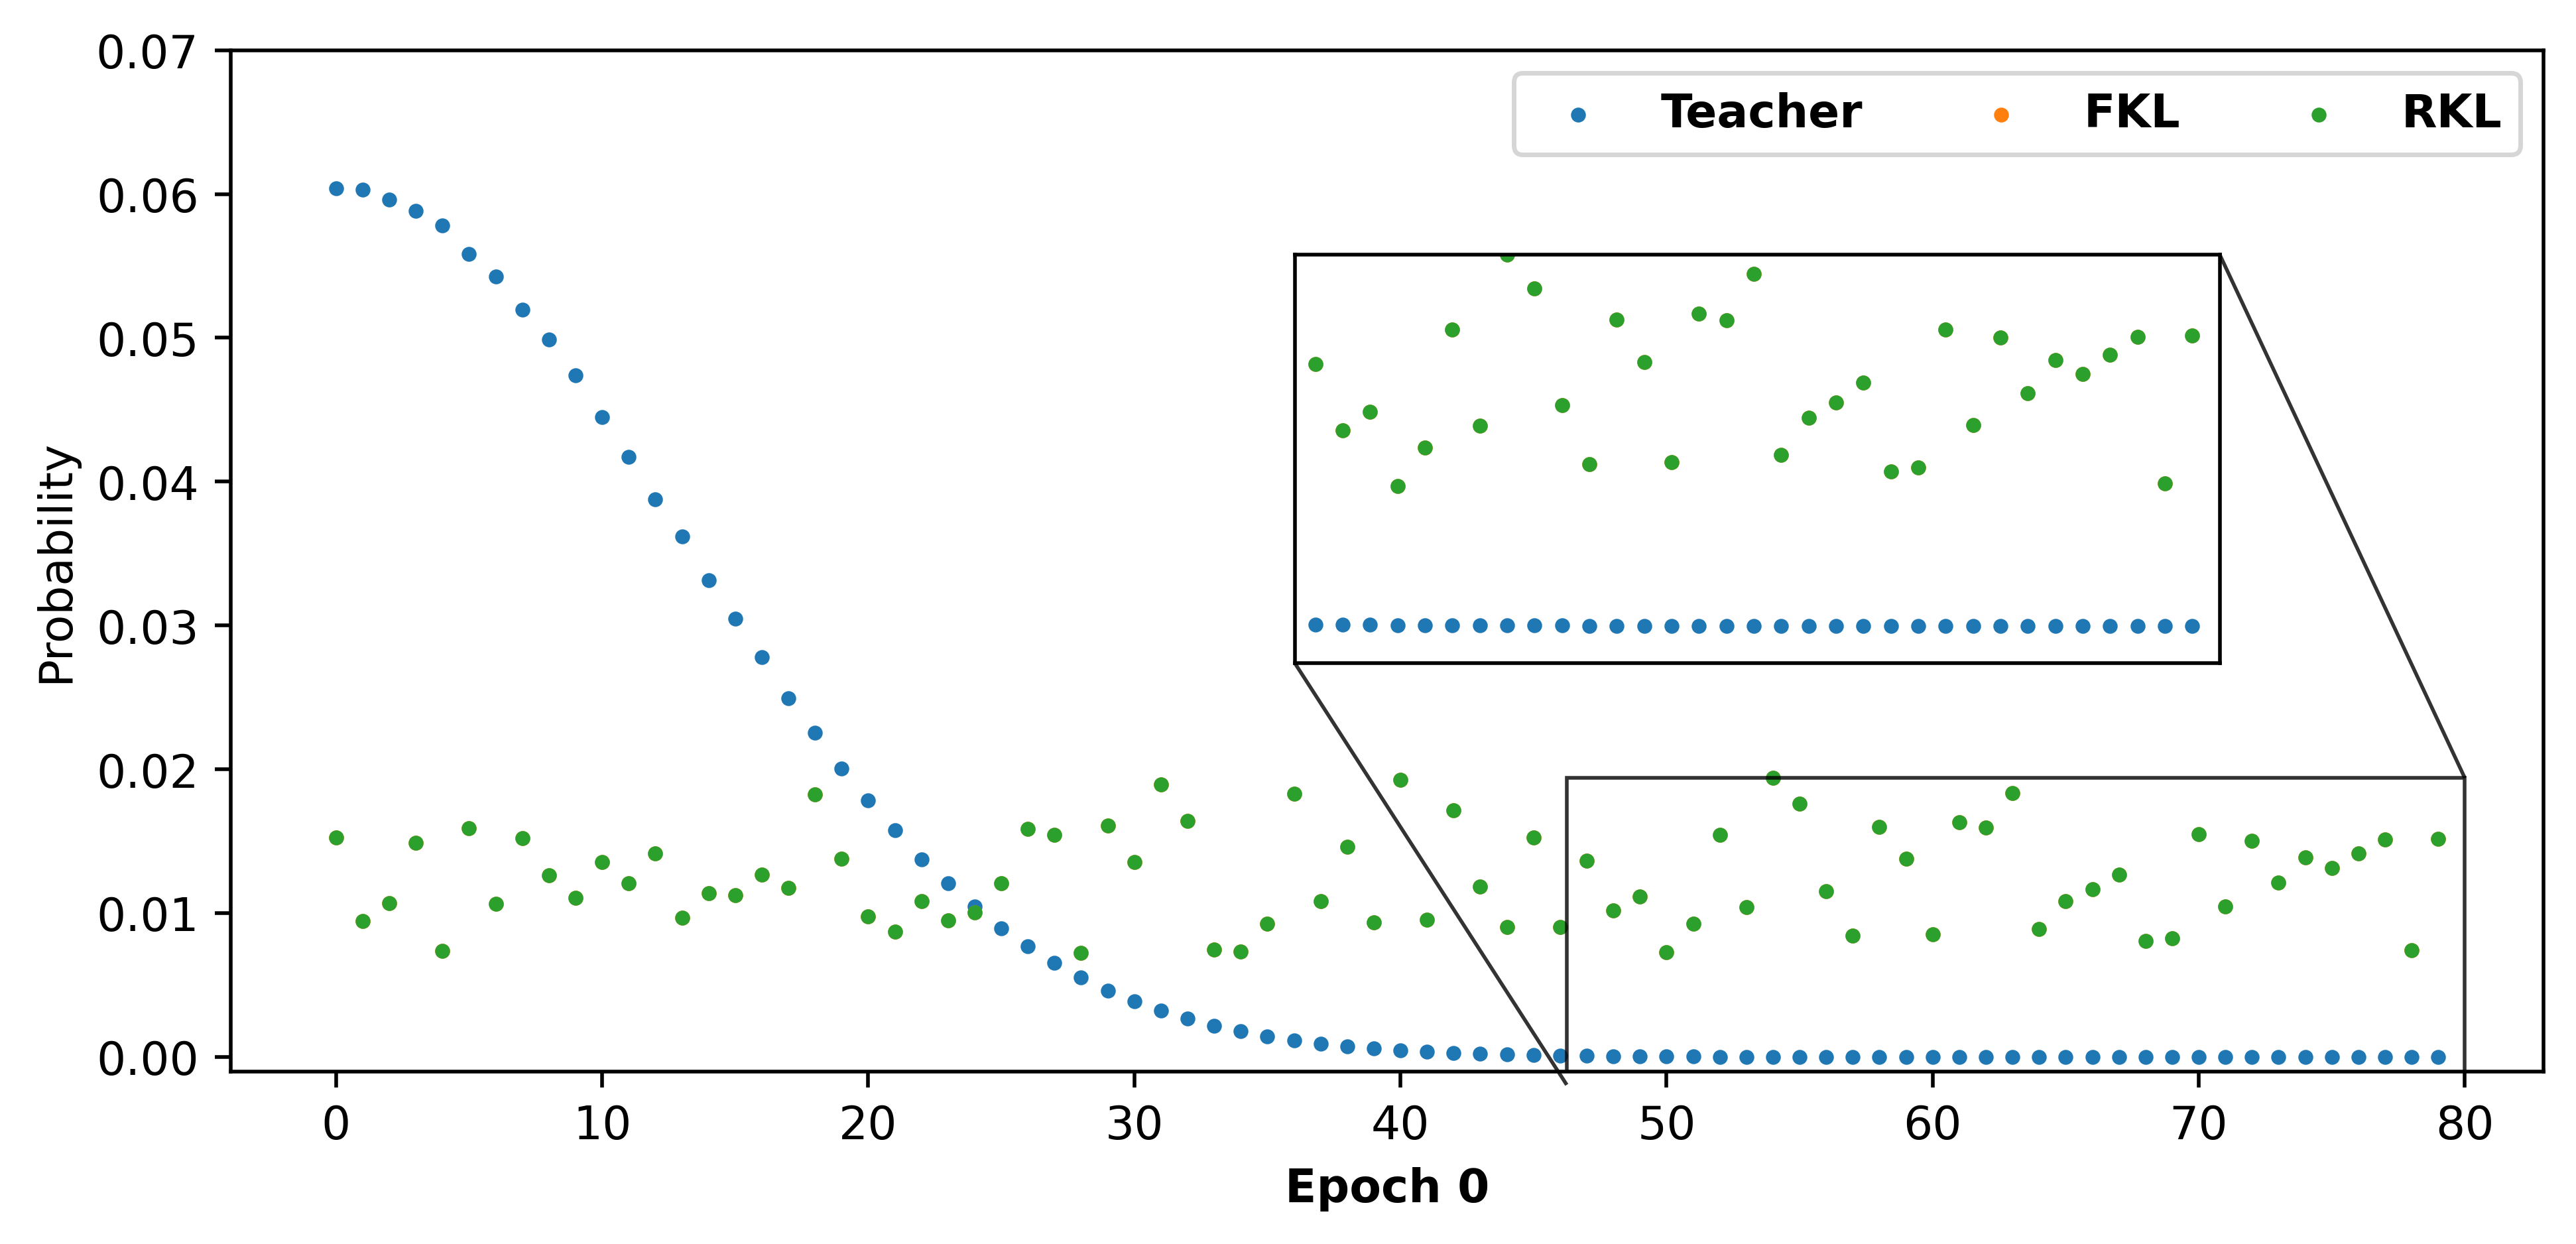

In [37]:
from matplotlib import animation
# blit=True re-draws only the parts that have changed.
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import rc
from matplotlib.animation import FuncAnimation, PillowWriter
print(animation.writers.list())

matplotlib.rcParams['animation.writer'] = "pillow"

X = np.arange(0,len(X), 1)
ss=20
fig, axs = plt.subplots(1,1, figsize=(9, 4), dpi=500)


def animate(idx):
    print(idx, end="-")
    axs.cla()
    axs.scatter(X,Y,  c='#1f77b4', marker='.', s=ss)
    axs.scatter(X,fq_s[idx], c='#ff7f0e', marker='.', s=ss)
    axs.scatter(X,rq_s[idx], c='#2ca02c', marker='.', s=ss)
    axs.set_ylim(-0.001, 0.07)

    axs.set_xlabel("Epoch {}".format(idx),weight='bold')
    axs.set_ylabel("Probability")
    
    axins = axs.inset_axes((0.46, 0.4, 0.4, 0.4))
    axins.scatter(X,Y,  c='#1f77b4', marker='.', s=ss)
    axins.scatter(X,fq_s[idx], c='#ff7f0e', marker='.', s=ss)
    axins.scatter(X,rq_s[idx], c='#2ca02c', marker='.', s=ss)
    axins.set_xlim(46.25,80)
    maxinum= max([max(Y[37:]), max(fq_s[idx][37:]), max(rq_s[idx][37:])])
    axins.set_ylim(-maxinum/10,maxinum)
    axins.yaxis.set_major_locator(plt.NullLocator())
    axins.xaxis.set_major_locator(plt.NullLocator())
    mark_inset(axs, axins, loc1=1, loc2=3, fc="none", ec='k', lw=0.8, alpha=0.8)

    # font = font_manager.FontProperties(weight='bold',style='normal', size=10)
    # # fig.legend(loc='best')
    legendEntries = ("Teacher","FKL","RKL")
    # # set figure legend entries, number of columns, location
    axs.legend(legendEntries,ncol=len(legendEntries), title_fontsize="x-large",prop=font)
    # # fig.suptitle("Epoch 50")
    # plt.tight_layout()
    
    return axs

anim = animation.FuncAnimation(fig, animate, frames=200, interval=20, blit=False)

writer = animation.PillowWriter(fps=6,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
anim.save('scatter.gif', writer=writer)